In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import h5py
from collections import Counter

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Activation, Add, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [7]:
# paths
train_path = "IsoDatasetPro/Train"
val_path = "IsoDatasetPro/Val"
test_path = "IsoDatasetPro/Test"

num_classes = {"root": 14, "bass": 14, "triad": 8, "fourth": 6}

In [8]:
# Data generating functions
def load_train():
    with h5py.File(os.path.join(train_path, 'train.h5'), "r") as f:
        dataset = f['X_train'][:]
        root = f['root'][:]
        bass = f['bass'][:]
        triad = f['triad'][:]
        fourth = f['fourth'][:]
        return dataset, root, bass, triad, fourth

def load_val():
    with h5py.File(os.path.join(val_path, 'val.h5'), "r") as f:
        dataset = f['X_val'][:]
        root = f['root'][:]
        bass = f['bass'][:]
        triad = f['triad'][:]
        fourth = f['fourth'][:]
        return dataset, root, bass, triad, fourth

def load_test():
    with h5py.File(os.path.join(test_path, 'test.h5'), "r") as f:
        dataset = f['X_test'][:]
        root = f['root'][:]
        bass = f['bass'][:]
        triad = f['triad'][:]
        fourth = f['fourth'][:]
        return dataset, root, bass, triad, fourth

# Initialize batch size
batch_size = 64



In [9]:
result = load_train()
X_train = result[0]
root_train = result[1]
bass_train = result[2]
triad_train = result[3]
fourth_train = result[4]
gc.collect()
del result

result = load_val()
X_val = result[0]
root_val = result[1]
bass_val = result[2]
triad_val = result[3]
fourth_val = result[4]
gc.collect()
del result

result = load_test()
X_test = result[0]
root_test = result[1]
bass_test = result[2]
triad_test = result[3]
fourth_test = result[4]
gc.collect()
del result

In [10]:
# print(triad_train[3][5])

In [11]:

# Get labels for each output (convert from one-hot encoding to class indices)
root_labels = np.argmax(root_train, axis=2).flatten()
# bass_labels = np.argmax(bass_train, axis=2).flatten()
triad_labels = np.argmax(triad_train, axis=2).flatten()
# fourth_labels = np.argmax(fourth_train, axis=2).flatten()

root_counts = Counter(root_labels)
# bass_counts = Counter(bass_labels)
triad_counts = Counter(triad_labels)
# fourth_counts = Counter(fourth_labels)

# print("Class counts:", len(root_counts))
# print("\nClass counts:", len(bass_counts))
# print("\nClass counts:", len(triad_counts))
# print("\nClass counts:", len(fourth_counts))

total_root_samples = sum(root_counts.values())
# total_bass_samples = sum(bass_counts.values())
total_triad_samples = sum(triad_counts.values())
# total_fourth_samples = sum(fourth_counts.values())

min_value = 1.0
max_value = 5.0 

root_weight_dict = {
    class_label: max(1, min((total_root_samples / (len(root_counts) * count)), 5.0)) if count > 0 else 0
    for class_label, count in root_counts.items()
}

# bass_weight_dict = {
#     class_label: max(min_value, min((total_bass_samples / (len(bass_counts) * count)), max_value)) if count > 0 else 0
#     for class_label, count in bass_counts.items()
# }

triad_weight_dict = {
    class_label: max(min_value, min((total_triad_samples / (len(triad_counts) * count)), max_value)) if count > 0 else 0
    for class_label, count in triad_counts.items()
}

# fourth_weight_dict = {
#     class_label: max(min_value, min((total_fourth_samples / (len(fourth_counts) * count)), max_value)) if count > 0 else 0
#     for class_label, count in fourth_counts.items()
# }

# print(root_weight_dict)
# print(bass_weight_dict)
# print(triad_weight_dict)
# print(fourth_weight_dict)


In [12]:

def weighted_categorical_crossentropy(weight_dict):
    """Custom loss function to apply class weights to categorical crossentropy."""
    def loss(y_true, y_pred):
        # Add epsilon to avoid log(0) and division by zero
        epsilon = 1e-8

        # Ensure that both y_true and y_pred are cast to float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Add epsilon to avoid log(0)
        y_true = tf.clip_by_value(y_true, epsilon, 1.0)  # Clip to avoid exact zeros
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0)  # Clip to avoid exact zeros

        print(y_true)
        print(y_pred)
        

        # Get class indices
        class_indices = tf.argmax(y_true, axis=-1)
        # print((class_indices))


        # Convert dictionary to tensor
        weight_array = tf.constant([weight_dict.get(i, 1.0) for i in range(len(weight_dict))], dtype=tf.float32)


        # Gather class weights
        sample_weights = tf.gather(weight_array, class_indices)


        # Compute categorical crossentropy loss
        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

        # Apply class weights
        return loss * sample_weights
    return loss

def weighted_kldivergence(weight_dict):
    """Custom loss function to apply class weights to KL Divergence."""
    def loss(y_true, y_pred):
        # Add epsilon to avoid log(0) and division by zero
        epsilon = 1e-8

        # Ensure that both y_true and y_pred are cast to float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Add epsilon to avoid log(0)
        y_true = tf.clip_by_value(y_true, epsilon, 1.0)  # Clip to avoid exact zeros
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0)  # Clip to avoid exact zeros

        print(y_true)
        print(y_pred)
        

        # Get class indices
        class_indices = tf.argmax(y_true, axis=-1)
        # print((class_indices))


        # Convert dictionary to tensor
        weight_array = tf.constant([weight_dict.get(i, 1.0) for i in range(len(weight_dict))], dtype=tf.float32)


        # Gather class weights
        sample_weights = tf.gather(weight_array, class_indices)

        # print(sample_weights)

        # Compute KL divergence loss
        kl_div_loss = tf.reduce_sum(y_true * tf.math.log(y_true / y_pred), axis=-1)

        print(kl_div_loss * sample_weights)

        # Apply class weights
        return kl_div_loss * sample_weights
    return loss


In [13]:
# BI LSTM MODEL

# Learning rate decay after every 10 epochs
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.8  # Decrease by 20%
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Define input shape
input_shape = (300, 192)  # 192 cqt bins

# Input layer
input_layer = Input(shape=input_shape)

# # Dense Projection
# x = Dense(192, activation='relu')(input_layer)

# BiLSTM 1
x = Bidirectional(LSTM(96, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# BiLSTM 2
x = Bidirectional(LSTM(72, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# BiLSTM 3
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Additional BiLSTM Layer for deeper feature extraction
x = Bidirectional(LSTM(48, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Dense Layer
x = Dense(128, activation='sigmoid')(x)

# Outputs
root_output = Dense(14, activation='softmax', name="root_output")(x)
bass_output = Dense(14, activation='softmax', name="bass_output")(x)
triad_output = Dense(8, activation='softmax', name="triad_output")(x)
fourth_output = Dense(6, activation='softmax', name="fourth_output")(x)


# Define model
model = Model(inputs=input_layer, outputs=[root_output, bass_output, triad_output, fourth_output])

# Loss Dictionary
losses = {
    'root_output': 'categorical_crossentropy',
    'bass_output': 'categorical_crossentropy',
    'triad_output': weighted_kldivergence(triad_weight_dict),
    'fourth_output': 'categorical_crossentropy'
}

# Loss Weights (focus more on triad and fourth)
loss_weights = {
    "root_output": 2.0,
    "bass_output": 1.0,
    "triad_output": 4.0,
    "fourth_output": 0.5
}


# Compile model
model.compile(optimizer=Adam(learning_rate=0.0003),
              loss=losses,
              loss_weights=loss_weights,
              metrics = {
    "root_output": ["accuracy"], 
    "bass_output": ["accuracy"], 
    "triad_output": ["accuracy"], 
    "fourth_output": ["accuracy"]
}
)

# Model summary
model.summary()


W0000 00:00:1743363096.010657     624 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 192)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 300, 192)  │    221,952 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 300, 192)  │        768 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300, 192)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 300, 144)  │    152,640 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 144)  │        576 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 300, 144)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 300, 128)  │    107,008 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 128)  │        512 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 300, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 300, 96)   │     67,968 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 96)   │        384 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 300, 96)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 300, 128)  │     12,416 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ root_output (Dense) │ (None, 300, 14)   │      1,806 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bass_output (Dense) │ (None, 300, 14)   │      1,806 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ triad_output        │ (None, 300, 8)    │      1,032 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourth_output       │ (None, 300, 6)    │        774 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 569,642 (2.17 MB)

 Trainable params: 568,522 (2.17 MB)

 Non-trainable params: 1,120 (4.38 KB)

X_train shape: (6144, 300, 192)
root_train shape: (6144, 300, 14)
bass_train shape: (6144, 300, 14)
triad_train shape: (6144, 300, 8)
fourth_train shape: (6144, 300, 6)
X_val shape: (1265, 300, 192)
root_val shape: (1265, 300, 14)
bass_val shape: (1265, 300, 14)
triad_val shape: (1265, 300, 8)
fourth_val shape: (1265, 300, 6)
Epoch 1/50
Tensor("compile_loss/loss/clip_by_value:0", shape=(32, 300, 8), dtype=float32)
Tensor("compile_loss/loss/clip_by_value_1:0", shape=(32, 300, 8), dtype=float32)
Tensor("compile_loss/loss/mul_1:0", shape=(32, 300), dtype=float32)
Tensor("compile_loss/loss/clip_by_value:0", shape=(32, 300, 8), dtype=float32)
Tensor("compile_loss/loss/clip_by_value_1:0", shape=(32, 300, 8), dtype=float32)
Tensor("compile_loss/loss/mul_1:0", shape=(32, 300), dtype=float32)
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - bass_output_accuracy: 0.2089 - bass_output_loss: 2.5115 - fourth_output_accuracy: 0.2665 - fourth_output_loss: 1.7063 - loss: 14.2345 - root_output_accuracy: 0.

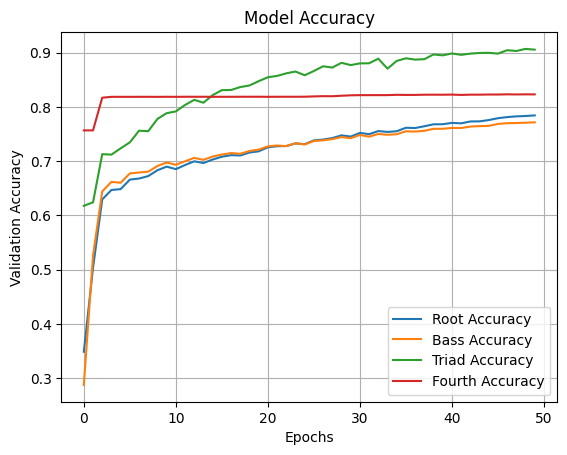

In [14]:
# Initialize model save path
model_save_path = "accordo_ai_model_CQT.keras"

print("X_train shape:", X_train.shape)
print("root_train shape:", root_train.shape)
print("bass_train shape:", bass_train.shape)
print("triad_train shape:", triad_train.shape)
print("fourth_train shape:", fourth_train.shape)

print("X_val shape:", X_val.shape)
print("root_val shape:", root_val.shape)
print("bass_val shape:", bass_val.shape)
print("triad_val shape:", triad_val.shape)
print("fourth_val shape:", fourth_val.shape)


class ValidationAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEpoch {epoch + 1} Validation Accuracies:")
        print(f"  Root Val Acc: {logs.get('val_root_output_accuracy', 0) * 100:.2f}%")
        print(f"  Bass Val Acc: {logs.get('val_bass_output_accuracy', 0) * 100:.2f}%")
        print(f"  Triad Val Acc: {logs.get('val_triad_output_accuracy', 0) * 100:.2f}%")
        print(f"  Fourth Val Acc: {logs.get('val_fourth_output_accuracy', 0) * 100:.2f}%")
        print("-" * 50)



# Train the model
history = model.fit(
    X_train,
    {"root_output": root_train, 
     "bass_output": bass_train, 
     "triad_output": triad_train, 
     "fourth_output": fourth_train},
    validation_data=(X_val, 
                     {"root_output": root_val, 
                      "bass_output": bass_val, 
                      "triad_output": triad_val, 
                      "fourth_output": fourth_val}),
    epochs=50, 
    batch_size=32,
    verbose=1,
    callbacks=[lr_callback, ValidationAccuracyCallback()]
)


# Evaluate the model on the test data
test_result = model.evaluate(
    X_test, 
    {"root_output": root_test, 
     "bass_output": bass_test, 
     "triad_output": triad_test, 
     "fourth_output": fourth_test},
)


test_root_acc = test_result[1] * 100
test_bass_acc = test_result[2] * 100
test_triad_acc = test_result[3] * 100
test_fourth_acc = test_result[4] * 100

print(f"\n\nTest Accuracy - Root: {test_root_acc:.2f}%, Bass: {test_bass_acc:.2f}%, Triad: {test_triad_acc:.2f}%, Fourth: {test_fourth_acc:.2f}%")

# Plot the accuracy curve
plt.plot(history.history['val_root_output_accuracy'], label='Root Accuracy')
plt.plot(history.history['val_bass_output_accuracy'], label='Bass Accuracy')
plt.plot(history.history['val_triad_output_accuracy'], label='Triad Accuracy')
plt.plot(history.history['val_fourth_output_accuracy'], label='Fourth Accuracy')
plt.title('Model Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# # Test on a small batch
# y_true = triad_train[:6][2] # Ground truth (e.g., one-hot labels for triads)
# y_pred = triad_train[:6][3]  # Model predictions

# # Manually calculate the loss
# loss_value = weighted_kldivergence(triad_weight_dict)(y_true, y_pred)
# print("Loss value:", loss_value[0])


In [17]:

model_save_path = "accordo_ai_model_CQT8.keras"
model.save(model_save_path)
print("Model saved! New best accuracy recorded.")

Model saved! New best accuracy recorded.
